In [118]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

IMG_SIZE = 28
NUM_CHANNELS = 1
LATENT_SPACE_SIZE = 100

Training Explanation:

We have 2 models: The discriminator and the stacked model which is basically a combined generator and discriminator.

For each training epoch we gather a batch of half real images and their associated targets (1's) and half fake images and their associated targets (0's). We then train the discriminator on this batch so that it can learn to tell the difference between a real and fake image.

Next, we create a batch of random noise and train the stacked layers on this. For each image, we pass "1" as the target value. The random noise is fed into our generator which creates an image and then passes the image to the discriminator. If the discriminator figures out the image is fake, back propagation updates the weights of our generator (discriminator in the stacked model is frozen), making the generator even better at generating fake images.

In [119]:
# plot image
def plot_image(epoch, generator, samples=16):
    noise = np.random.normal(0, 1, (samples, LATENT_SPACE_SIZE))
    images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [IMG_SIZE, IMG_SIZE])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [120]:
# build generator
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_shape=(LATENT_SPACE_SIZE,), activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(IMG_SIZE * IMG_SIZE * NUM_CHANNELS, activation='tanh'))
    model.add(Reshape((IMG_SIZE, IMG_SIZE, NUM_CHANNELS)))
    
    return model

In [121]:
# build discriminator
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS)))
    model.add(Dense((IMG_SIZE * IMG_SIZE * NUM_CHANNELS), activation='relu'))
    model.add(Dense((IMG_SIZE * IMG_SIZE * NUM_CHANNELS // 2), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [122]:
# build stacked generator / discriminator
def build_stacked(generator, discriminator):
    
    # disable training on discriminator
    for layer in discriminator.layers:
        layer.trainable = False
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    return model

In [123]:
# train the model
def train_model(stacked, generator, discriminator, X_train, num_epochs=20000, batch_size=32, save_interval=500):
    print("Training...")
    for epoch in range(num_epochs):
        
        # train discriminator
        random_index = np.random.randint(0, len(X_train) - batch_size//2)
        legit_images = X_train[random_index : random_index + batch_size//2].reshape(batch_size//2, IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
        gen_noise = np.random.normal(0, 1, (batch_size//2, LATENT_SPACE_SIZE))
        fake_images = generator.predict(gen_noise)
        
        X_combined_batch = np.concatenate((legit_images, fake_images))
        y_combined_batch = np.concatenate((np.ones((batch_size//2, 1)), np.zeros((batch_size//2, 1))))
        d_loss = discriminator.train_on_batch(X_combined_batch, y_combined_batch)

        # train generator
        noise = np.random.normal(0, 1, (batch_size, LATENT_SPACE_SIZE))
        y_mislabeled = np.ones((batch_size, 1))
        g_loss = stacked.train_on_batch(noise, y_mislabeled)

        if epoch % save_interval == 0:
            print("Epoch: " + str(epoch) + ", Discriminator: " + str(d_loss) + ", Generator: " + str(g_loss))
            plot_image(epoch, generator)

Training...


/home/jesse/.local/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0, Discriminator: 0.8342968, Generator: 0.9160643


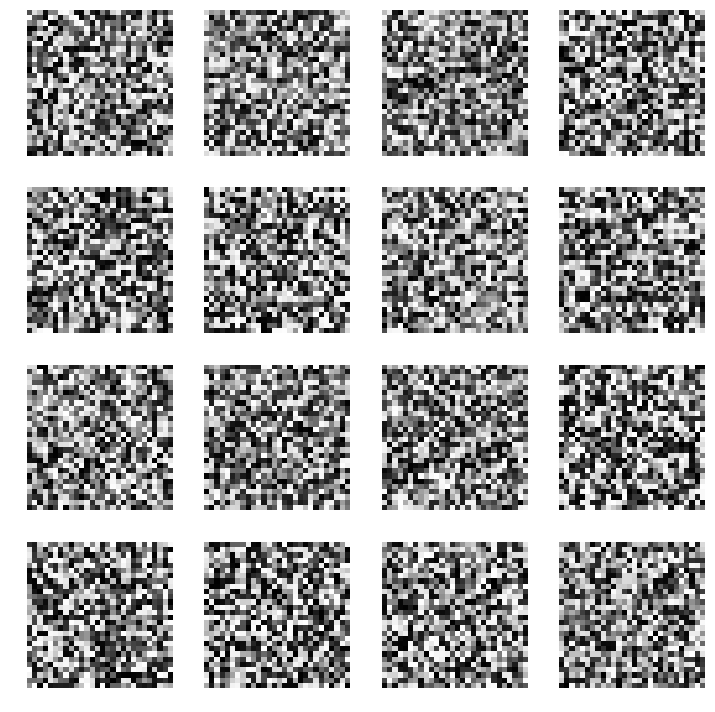

Epoch: 500, Discriminator: 0.37455577, Generator: 3.3967023


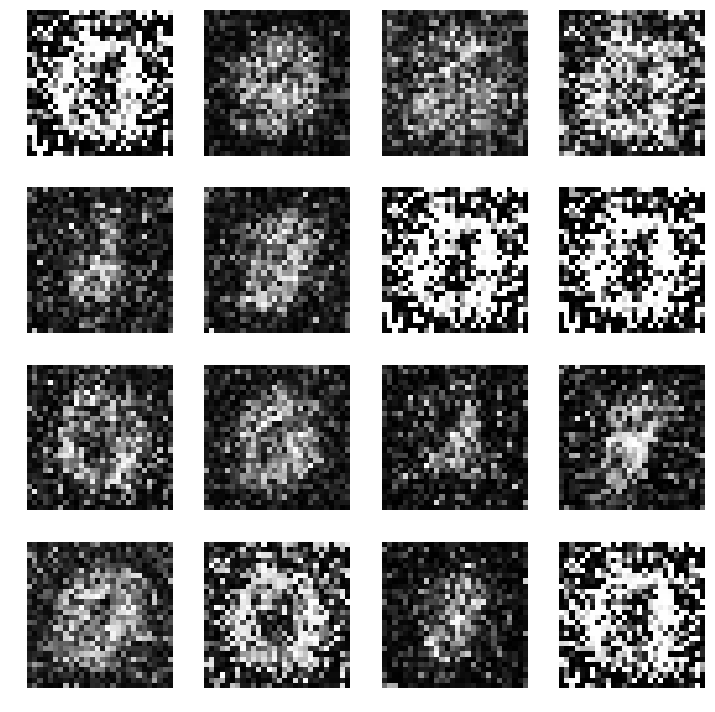

Epoch: 1000, Discriminator: 0.5692031, Generator: 0.85318667


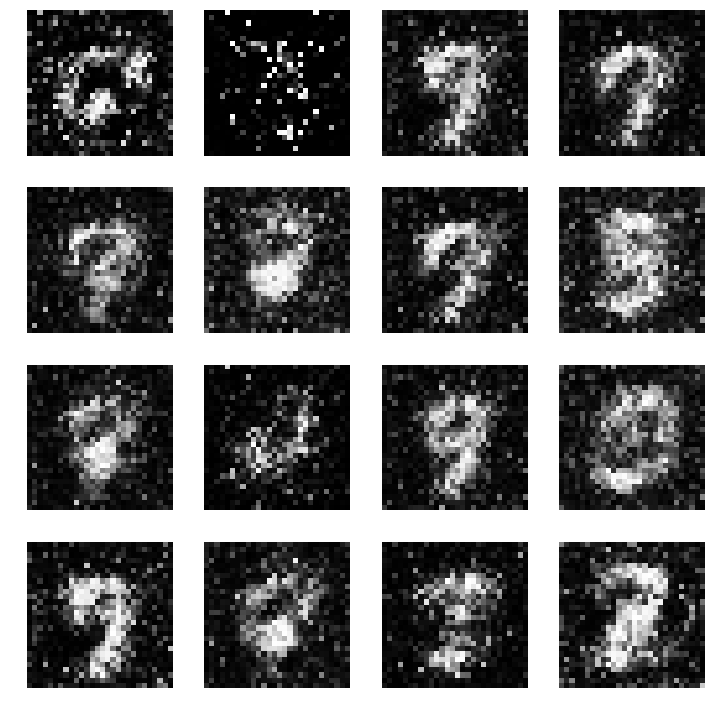

Epoch: 1500, Discriminator: 0.57619965, Generator: 0.9451574


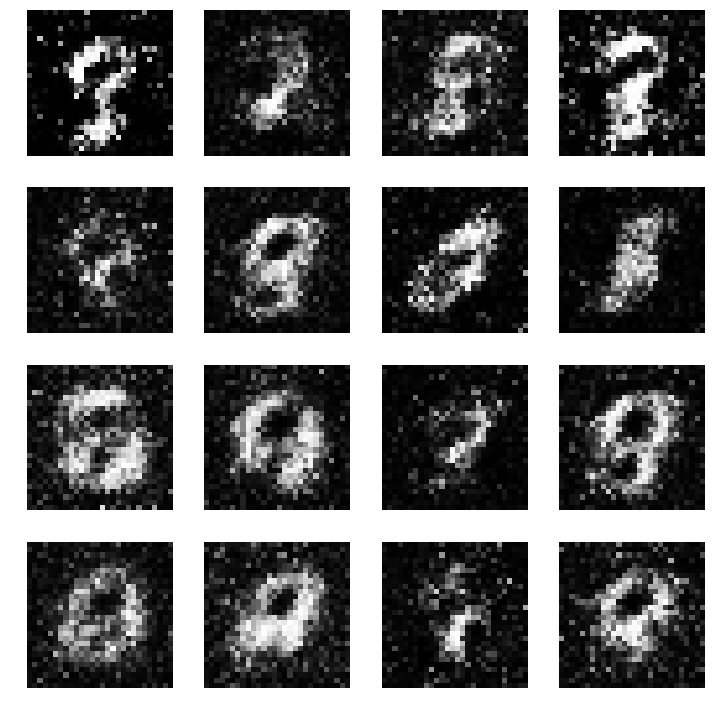

Epoch: 2000, Discriminator: 0.6143111, Generator: 0.90143645


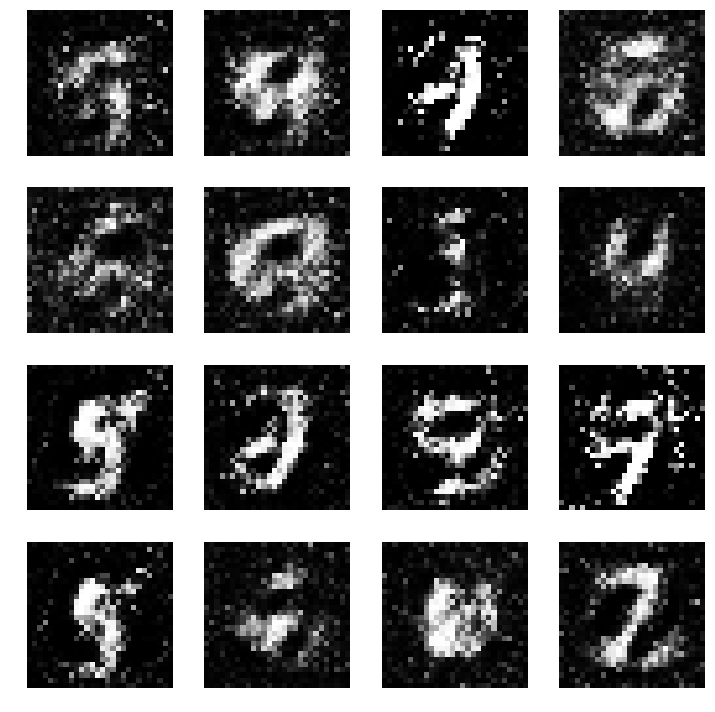

Epoch: 2500, Discriminator: 0.5742151, Generator: 0.879763


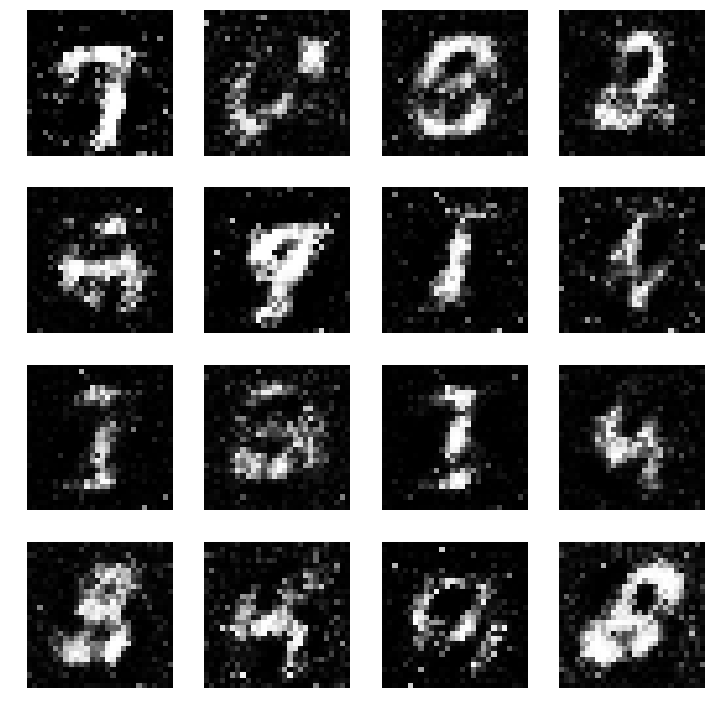

Epoch: 3000, Discriminator: 0.6185612, Generator: 0.8351586


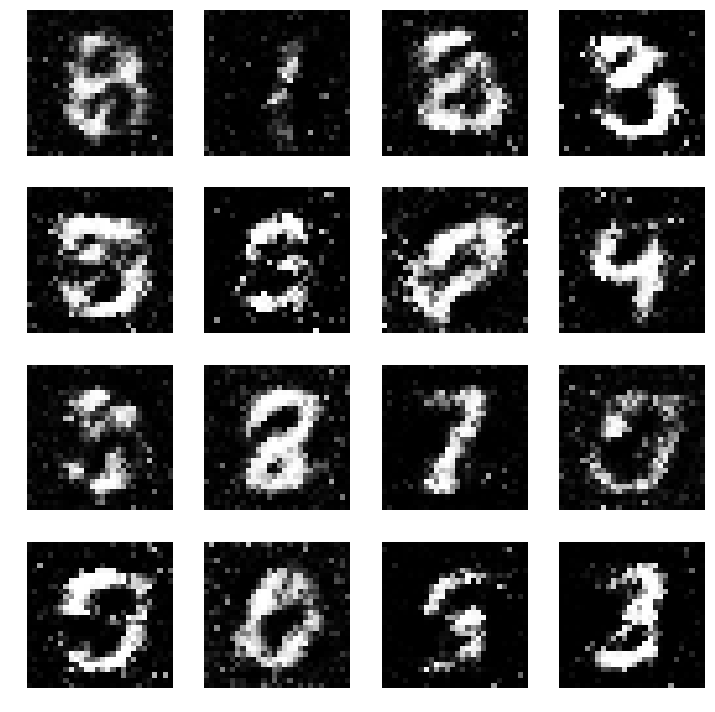

Epoch: 3500, Discriminator: 0.6502423, Generator: 0.7556409


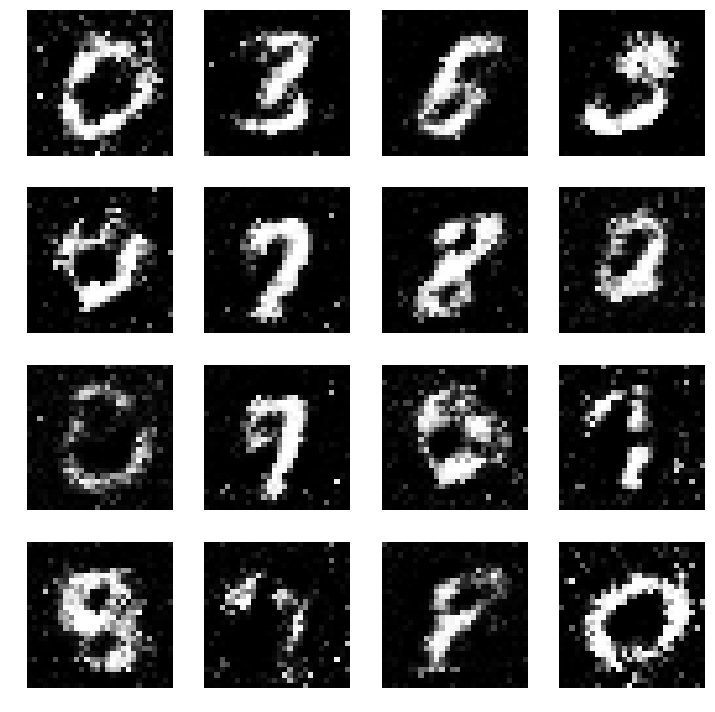

Epoch: 4000, Discriminator: 0.5270506, Generator: 1.0889288


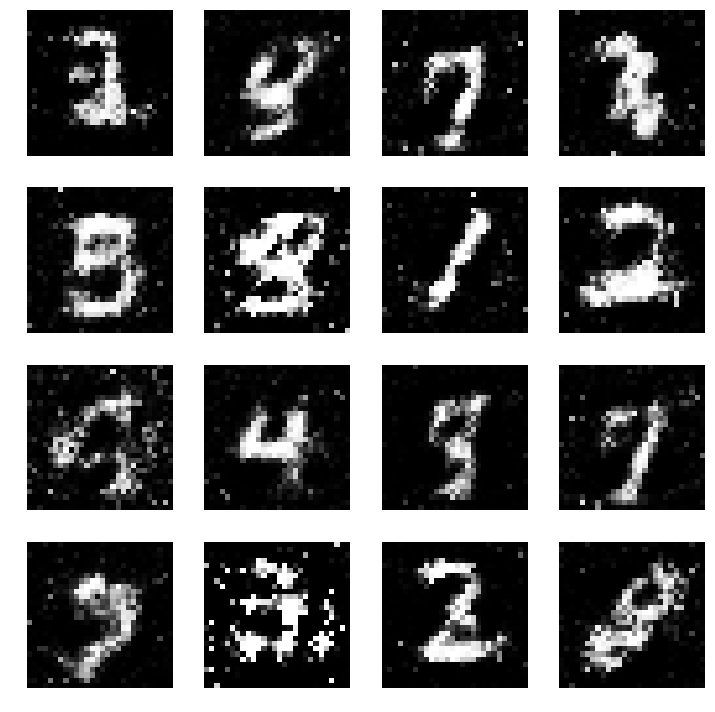

Epoch: 4500, Discriminator: 0.61462605, Generator: 0.9852007


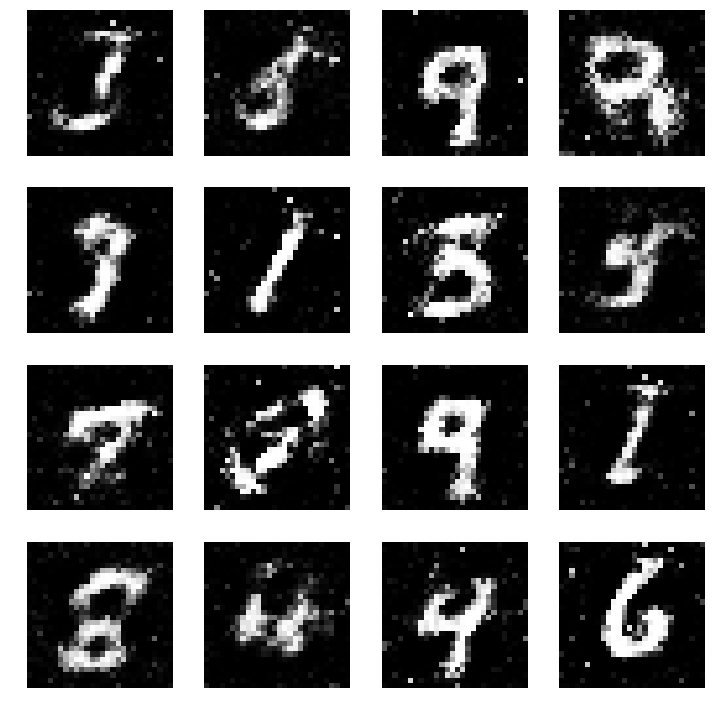

Epoch: 5000, Discriminator: 0.5975473, Generator: 0.67431116


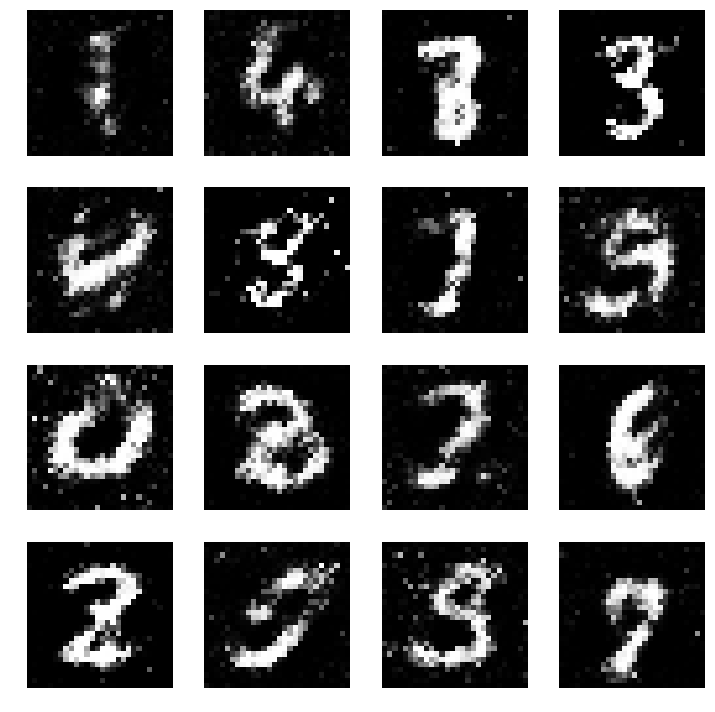

Epoch: 5500, Discriminator: 0.5325735, Generator: 1.0381346


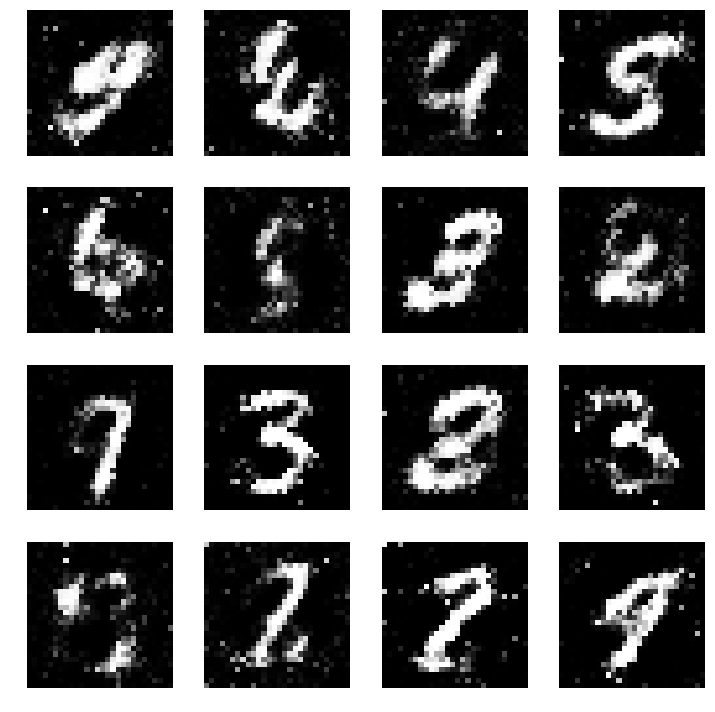

Epoch: 6000, Discriminator: 0.59797764, Generator: 0.7508651


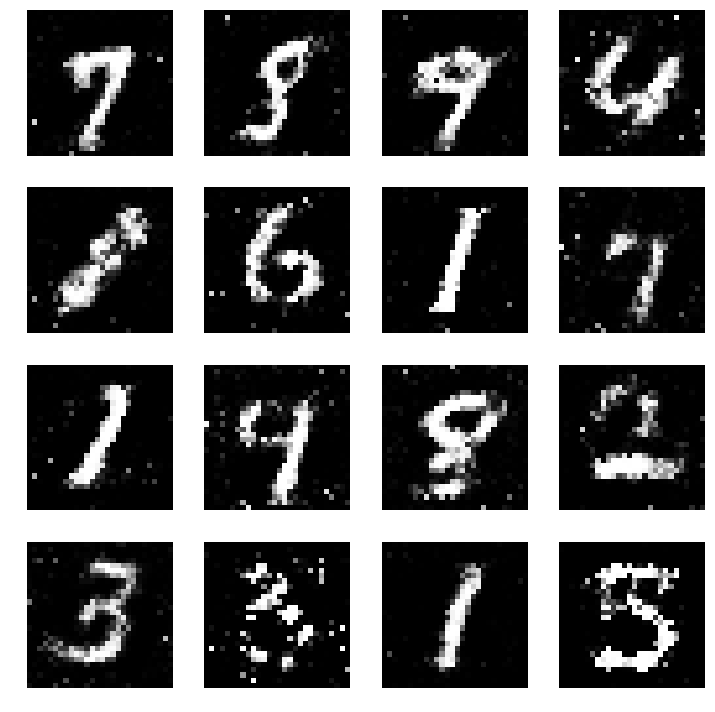

Epoch: 6500, Discriminator: 0.6745488, Generator: 0.8184926


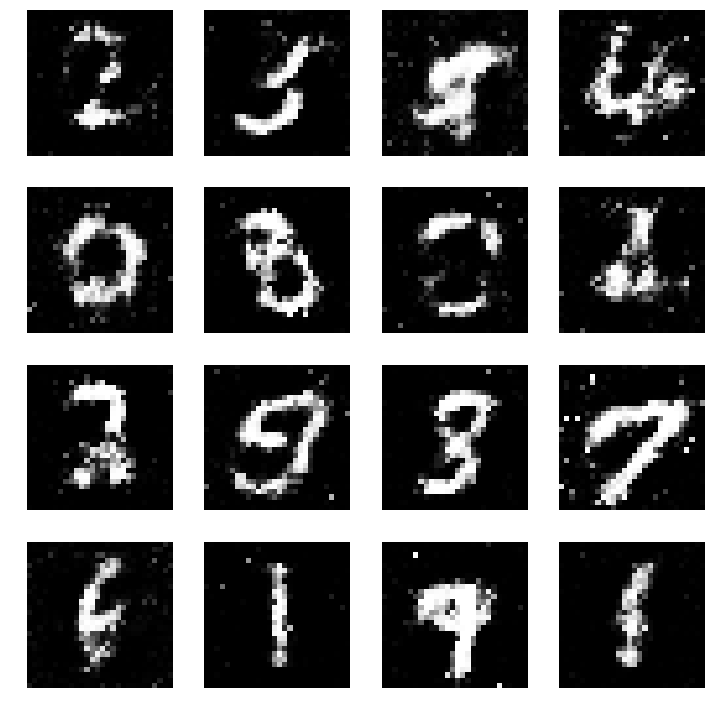

Epoch: 7000, Discriminator: 0.72170687, Generator: 0.85830873


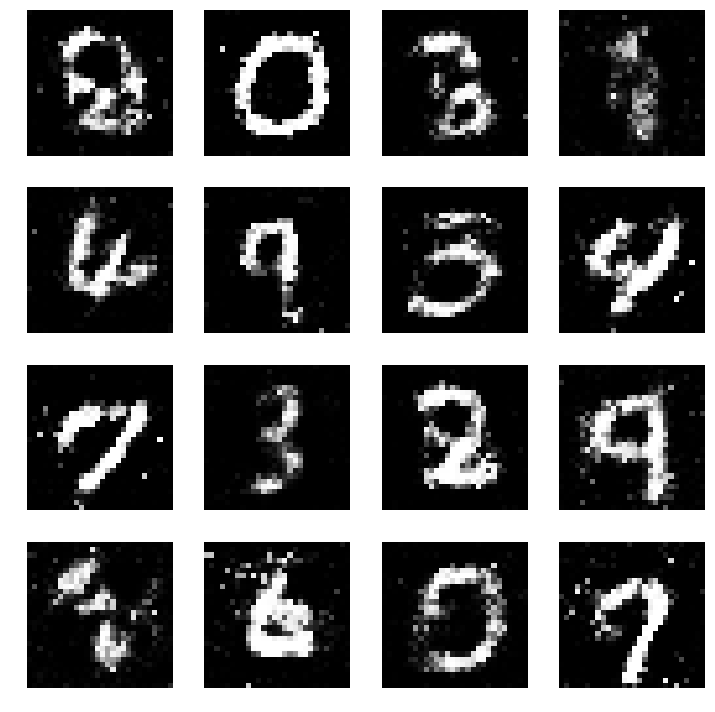

Epoch: 7500, Discriminator: 0.7272651, Generator: 0.7488451


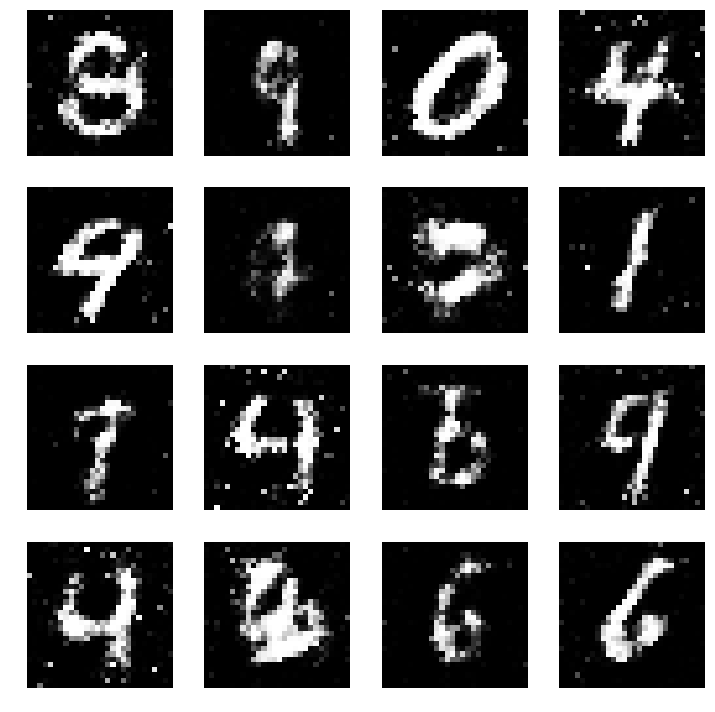

Epoch: 8000, Discriminator: 0.7285161, Generator: 0.68720466


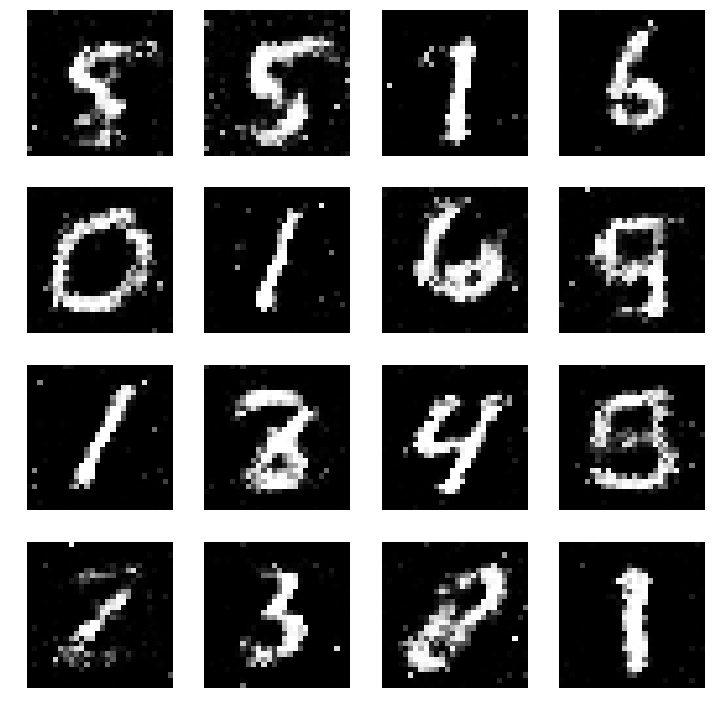

Epoch: 8500, Discriminator: 0.67211443, Generator: 0.8145447


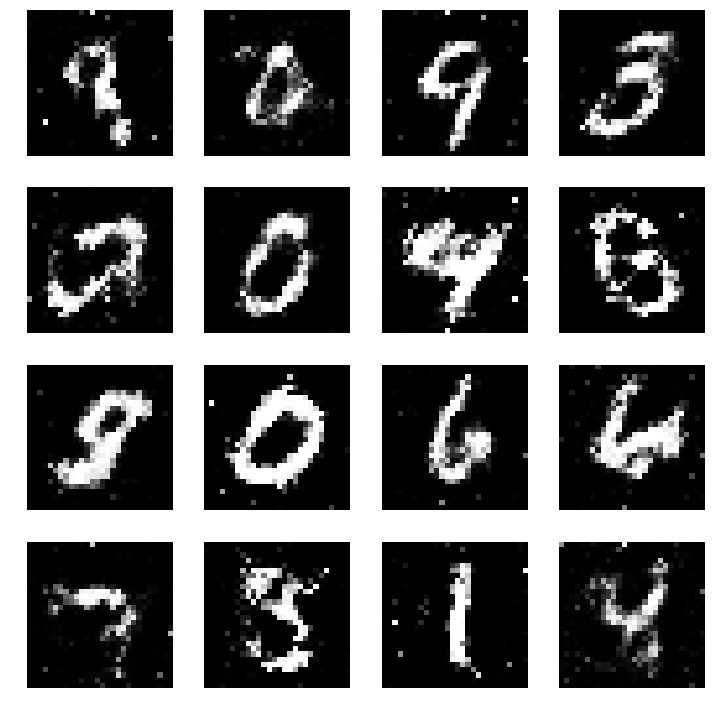

Epoch: 9000, Discriminator: 0.6168559, Generator: 0.8657106


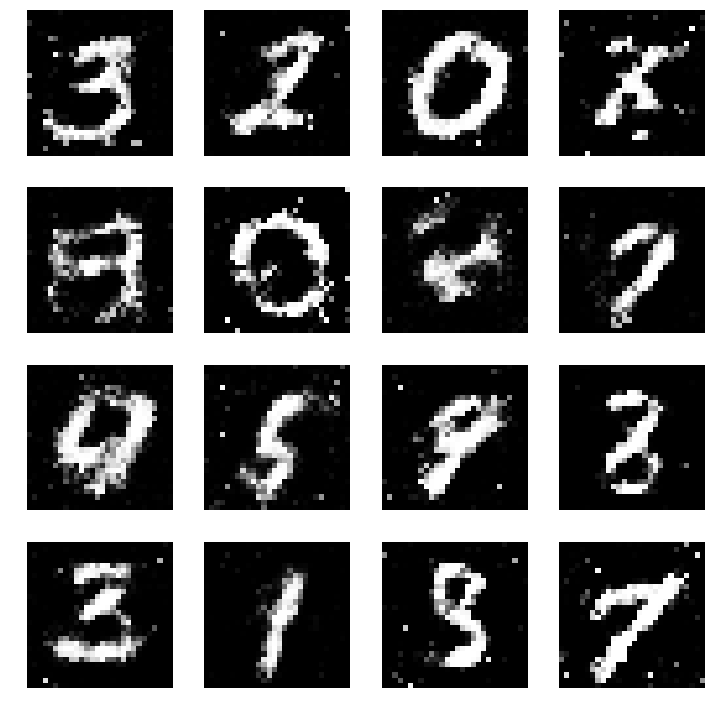

Epoch: 9500, Discriminator: 0.6080683, Generator: 0.90882117


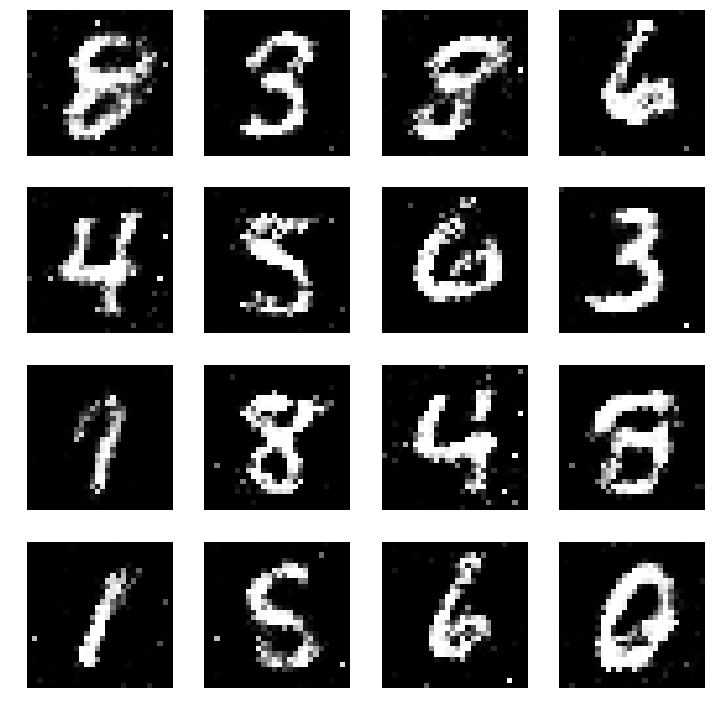

Epoch: 10000, Discriminator: 0.800979, Generator: 0.6769192


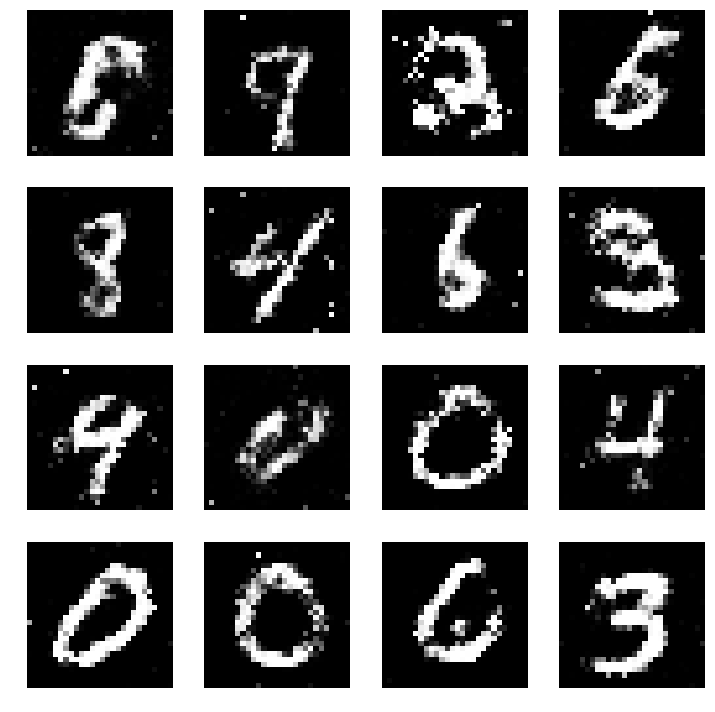

Epoch: 10500, Discriminator: 0.6680281, Generator: 0.80466586


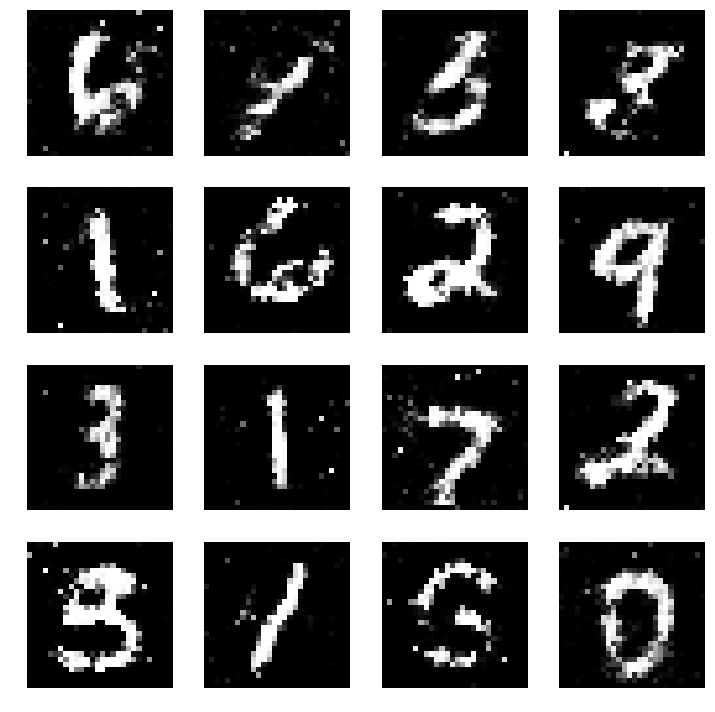

Epoch: 11000, Discriminator: 0.6681044, Generator: 0.74756444


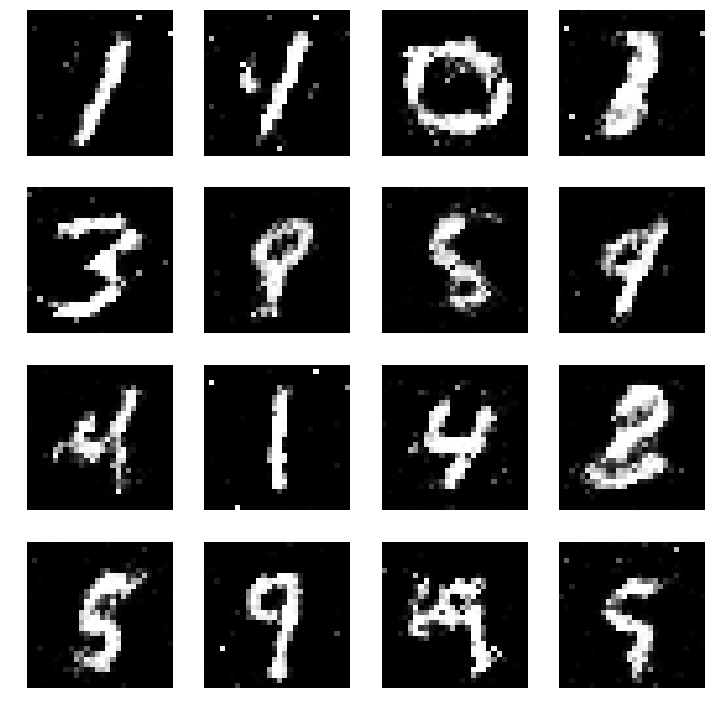

Epoch: 11500, Discriminator: 0.6912539, Generator: 0.93741727


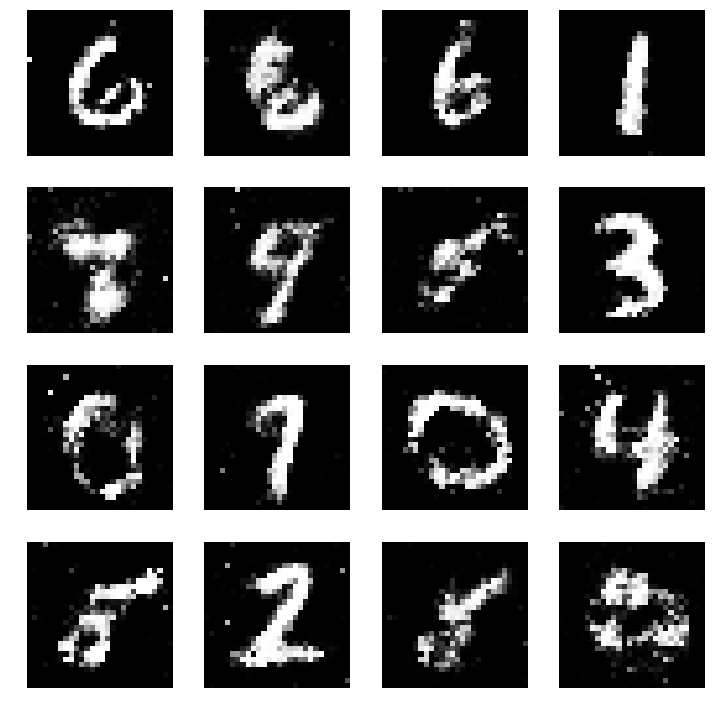

Epoch: 12000, Discriminator: 0.6992985, Generator: 0.7385159


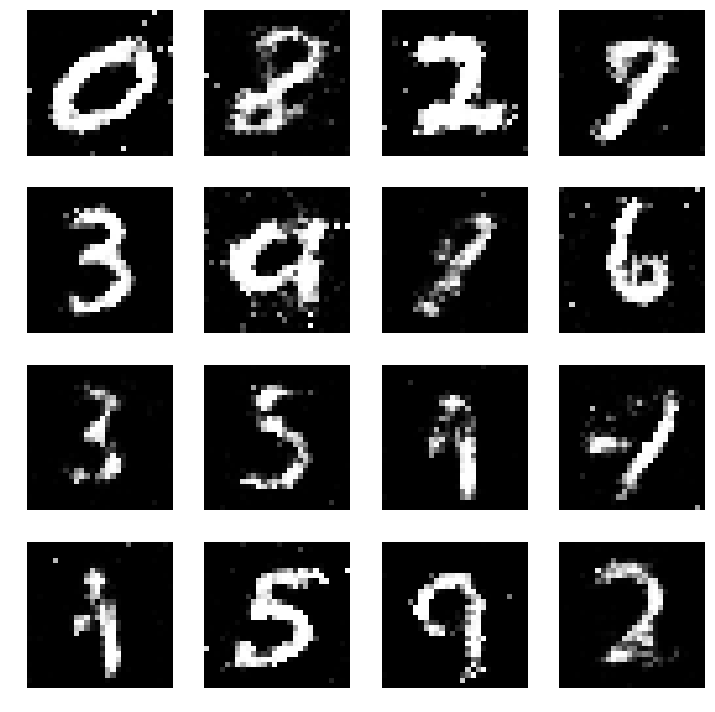

Epoch: 12500, Discriminator: 0.6860336, Generator: 0.72489417


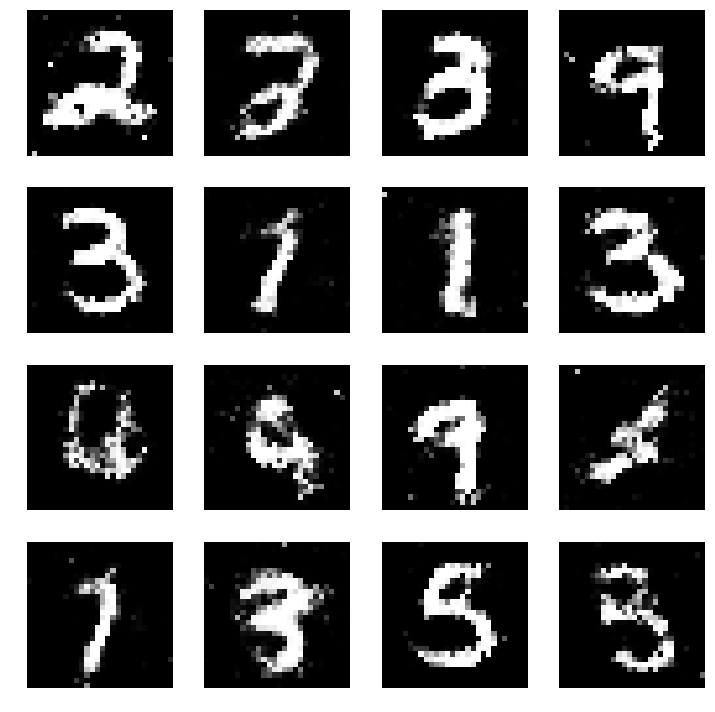

Epoch: 13000, Discriminator: 0.698906, Generator: 0.7081863


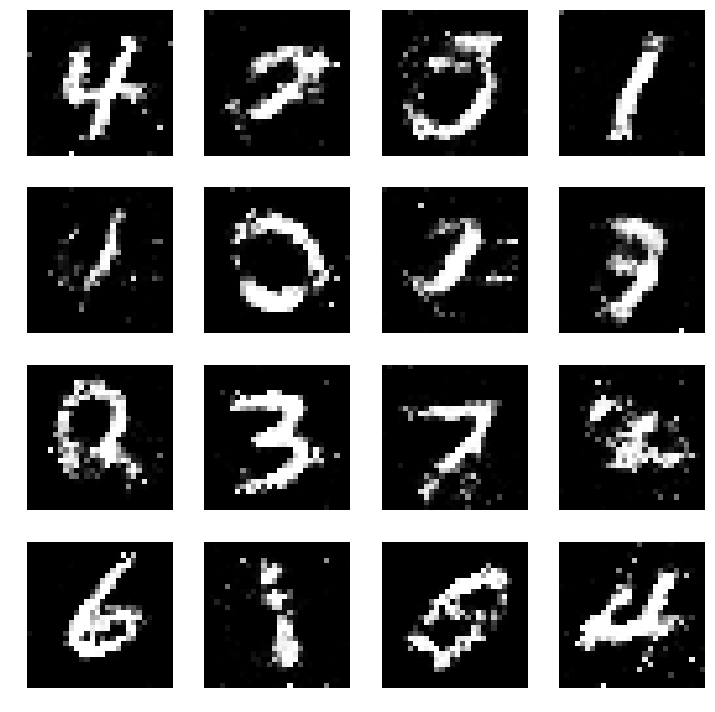

Epoch: 13500, Discriminator: 0.64268696, Generator: 0.7361561


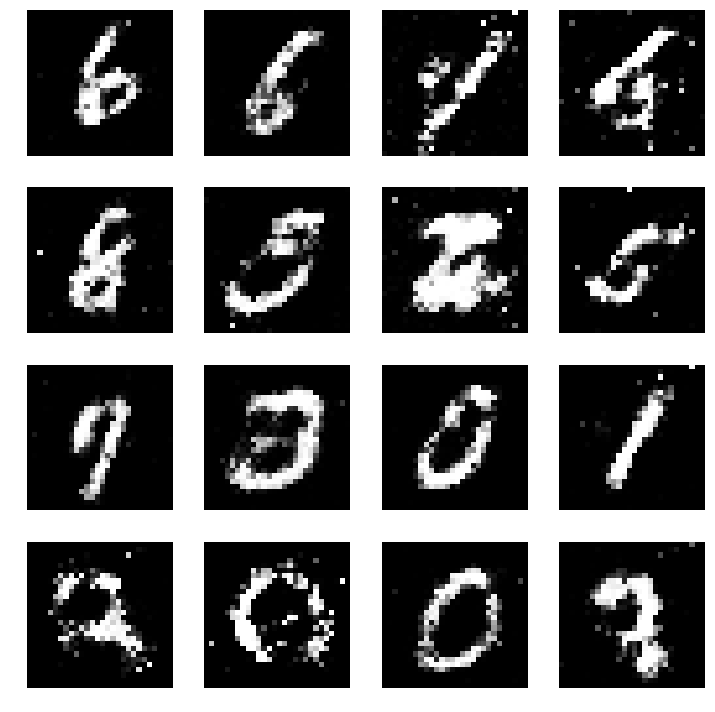

Epoch: 14000, Discriminator: 0.6758078, Generator: 0.7363354


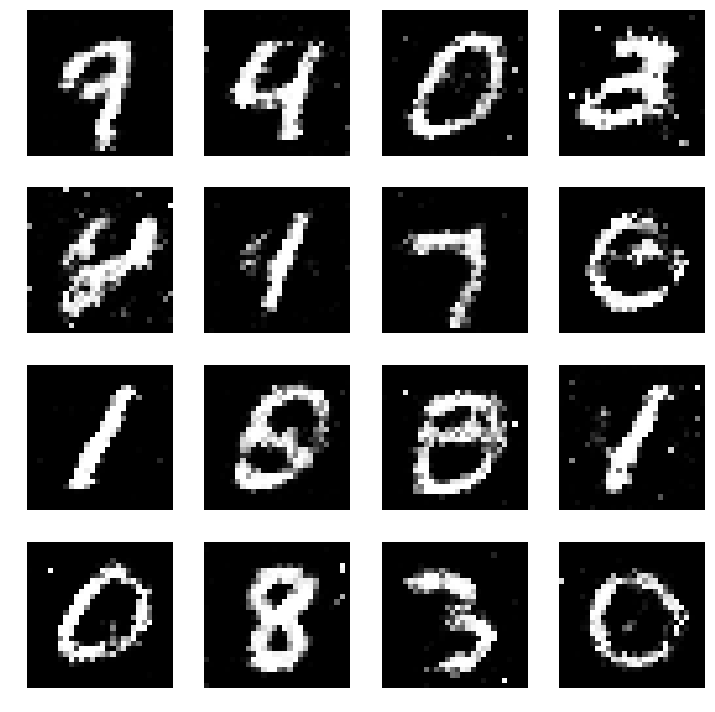

Epoch: 14500, Discriminator: 0.66750866, Generator: 0.71806


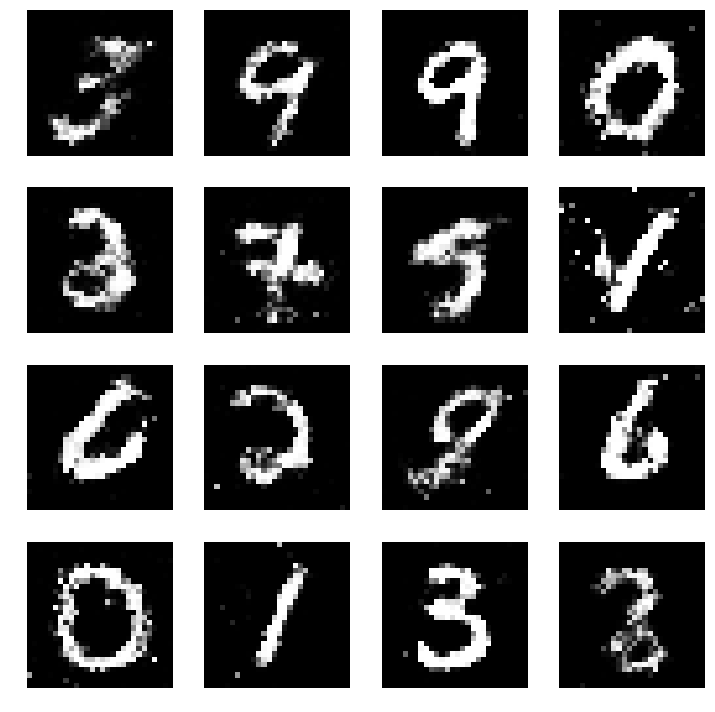

Epoch: 15000, Discriminator: 0.7316766, Generator: 0.7120133


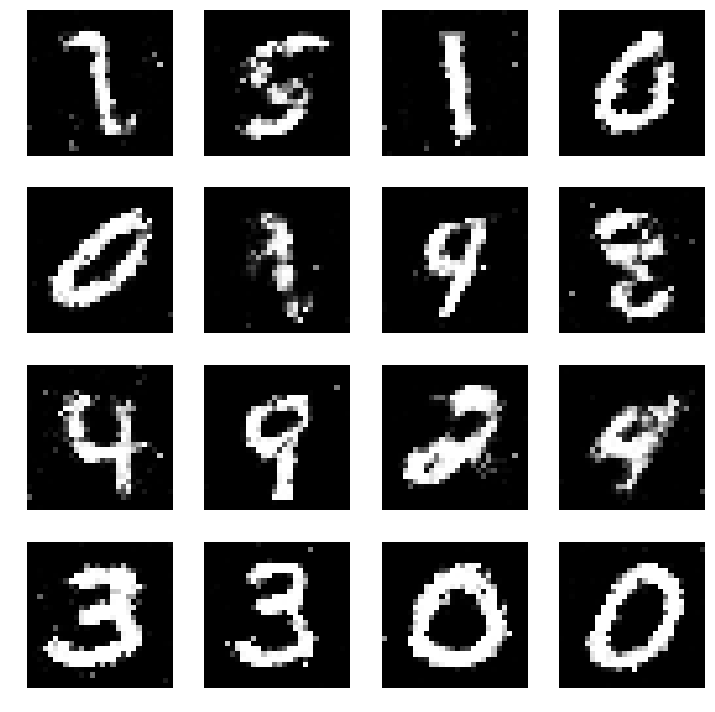

Epoch: 15500, Discriminator: 0.7230436, Generator: 0.696506


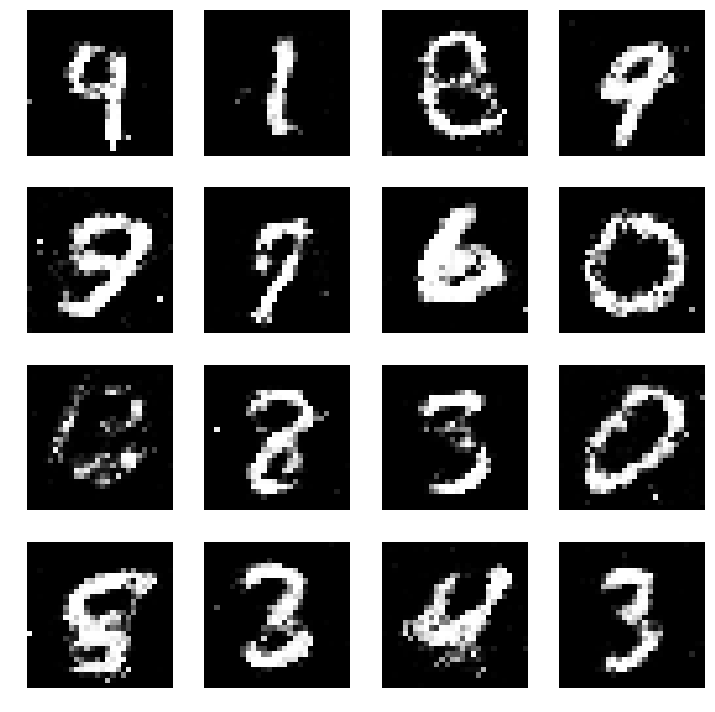

Epoch: 16000, Discriminator: 0.6723666, Generator: 0.7014284


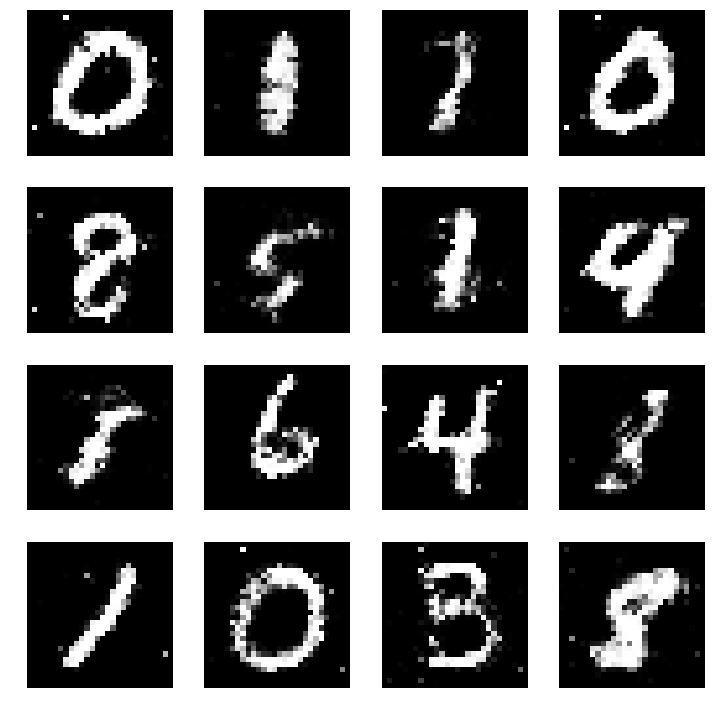

Epoch: 16500, Discriminator: 0.73057944, Generator: 0.6368427


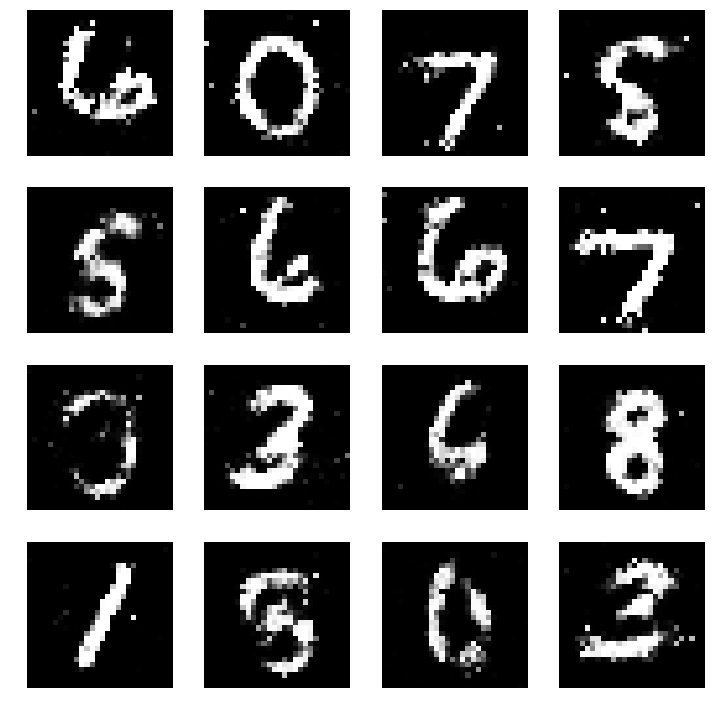

Epoch: 17000, Discriminator: 0.6966455, Generator: 0.73507655


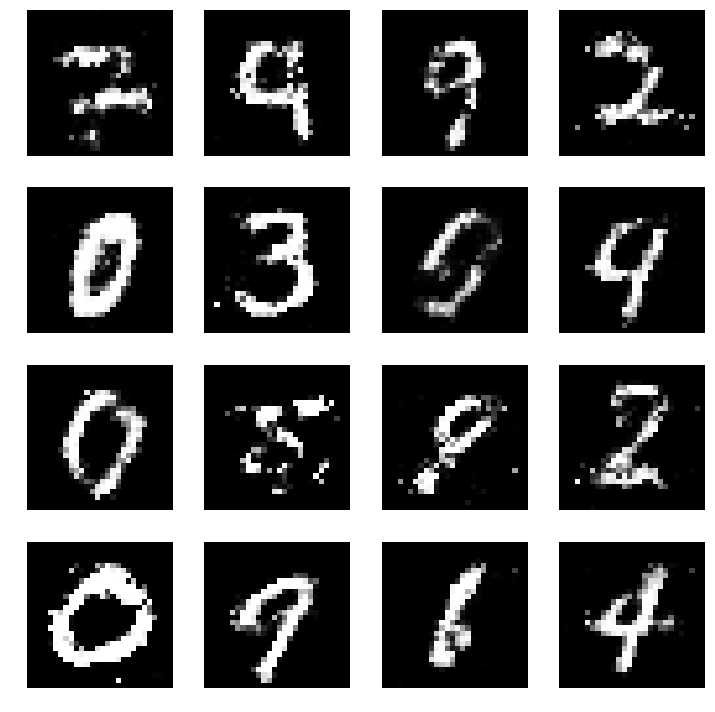

Epoch: 17500, Discriminator: 0.7181138, Generator: 0.7182384


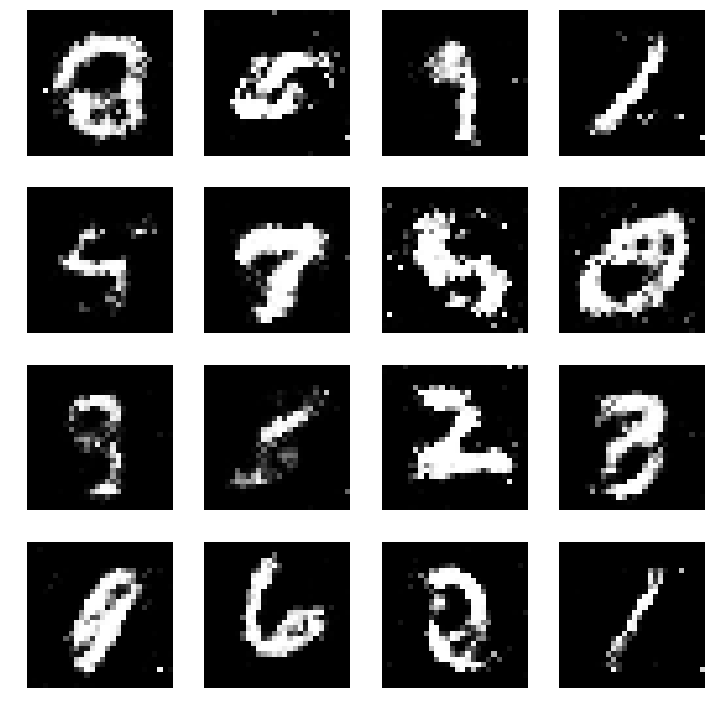

Epoch: 18000, Discriminator: 0.6811862, Generator: 0.7345015


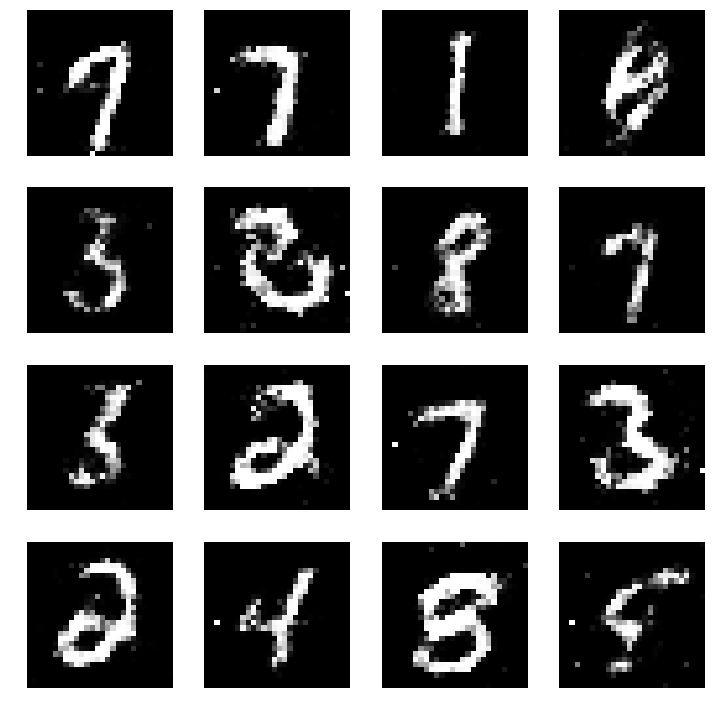

Epoch: 18500, Discriminator: 0.70420563, Generator: 0.66815543


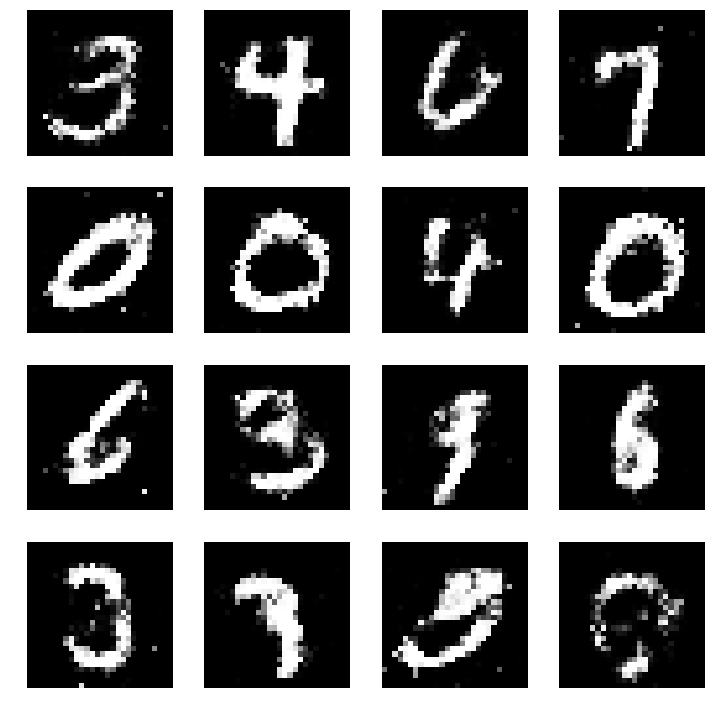

Epoch: 19000, Discriminator: 0.67990214, Generator: 0.71768105


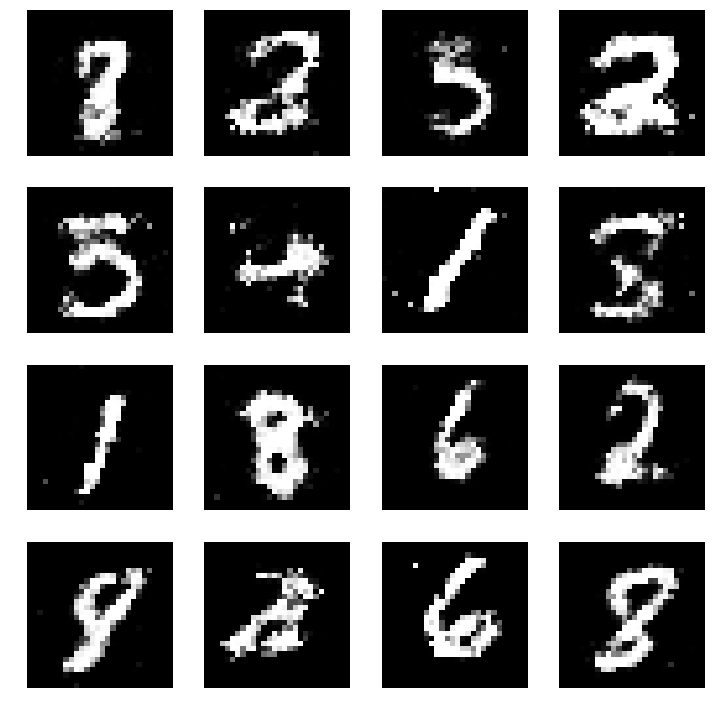

Epoch: 19500, Discriminator: 0.7131566, Generator: 0.74685824


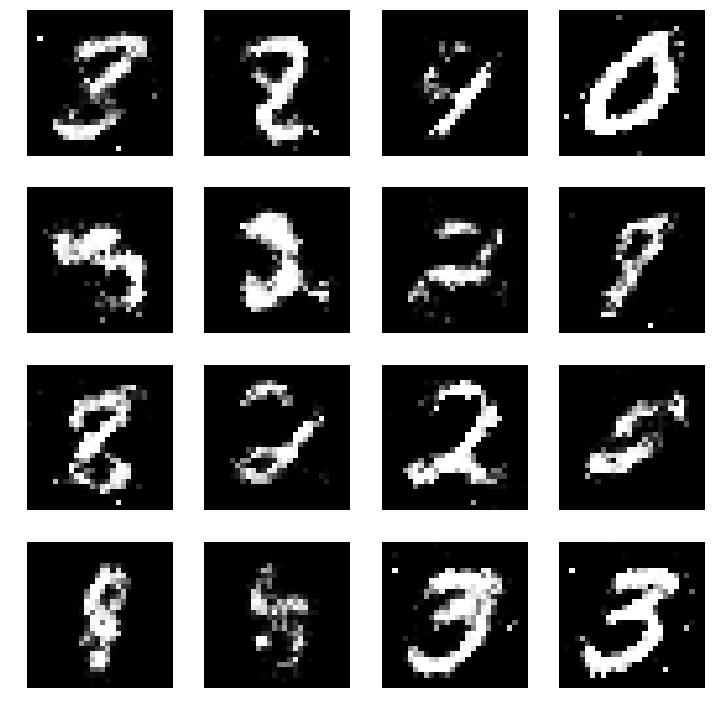

In [124]:
# load the MNIST data
(X_train, _), (_,_) = mnist.load_data()

# rescale -1 to 1
X_train = (X_train - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

generator = build_generator()
#generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, decay=8e-8))

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, decay=8e-8))

stacked = build_stacked(generator, discriminator)
stacked.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, decay=8e-8))

# train the model
train_model(stacked, generator, discriminator, X_train)